In [56]:
from collections import Counter

import torch
import torch.nn.functional as F
import torchaudio

import os
import pandas as pd
import numpy as np

from typing import (
    Union, 
    List, 
    Optional,
    Iterable,
    Callable,
    )
import seaborn as sns
import pymorphy3
import nltk
nltk.download('punkt_tab')
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
from pathlib import Path
import torch.nn as nn
from copy import deepcopy
from transformers import (
    BertTokenizer, 
    BertForSequenceClassification, 
    Trainer, 
    TrainingArguments,
    WhisperProcessor,
    WhisperForConditionalGeneration,
    pipeline,
    )
import transformers
from datasets import load_dataset, Features, Value, ClassLabel
from enum import Enum
import librosa
import librosa.display

from config import (
    SPEAKER_TEXT_FIELD_NAME,
    SPEAKER_EMOTION_FIELD_NAME,
    TEXT_2_EMOTION_FEATURE_FIELD_NAME,
    TEXT_2_EMOTION_TARGET_FIELD_NAME,
    TRAIN_PART_SIZE,
    RANDOM_SEED,
    TEST_PART_SIZE,
    PREDICTIONS_COL_NAME,
    TRUE_COL_NAME,
    TRANSCRIBED_KEYWORD,
    AUDIO_PATH_FIELD_NAME,
)

from configs.paths import (
    DEPLOMA_DIR_PATH,
    # DUSHA_DIR_PATH,
    # DUSHA_CROWD_DIR_PATH,
    # DUSHA_CROWD_TRAIN_DIR_PATH,
    DUSHA_CROWD_TRAIN_FILE_PATH,
    # DUSHA_TEST_PATH,
    RAW_CROWD_TEST_PATH,
)

from configs.datasets.dusha import (
    TEXT_COLUMN_NAME,
    DURATION_COLUMN_NAME,
    EMOTION_COLUMN_NAME,
)

from visualization.spectrum import (
    audio_path_2_show_spectrum,
)
from visualization.spectrogram import (
    audio_path_2_show_spectrogram,
)
from metrics.classification.confusion_matrix import (
    plot_confusion_matrix,
    show_all_classification_metrics,
)
from models.asr.whisper import (
    whisper_audio_file_2_transcription
)
from configs.paths import (
    DUSHA_CROWD_TEST_DIR_PATH,
    crowd_test_wav_path_2_abs_path,
)
from configs.base import (
    EMPTY,
)
from models.text2emotion.rubert_tiny2.confiig import (
    LABEL_FILED_NAME,
    SCORE_FIELD_NAME,
    MODEL_NAME as RUBERT_TINY2_MODEL_NAME,
)
from processing.text.embedding import (
    NAVEC,
    EMB,
    VOCAB,
    word_to_emb,
    text_2_unified_tensor,
    texts_series_2_tensor,
    bag_of_words,
)
from processing.text.normalization import (
    tokens_normalization,
    text_to_normalized_tokens,
)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/vkiselev/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%load_ext autoreload
%autoreload all

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Get text and duration dataframe

In [7]:
EXAMPLE_AUDIO_PATH:Path = Path('/home/vkiselev/data/other/univer/deploma/dusha/crowd/crowd_test/wavs/0004eb46b532c20b2f181f1a65d3ff17.wav')
raw_crowd_test = pd.read_csv(RAW_CROWD_TEST_PATH ,sep='\t')
# word embeddings

duration_text = raw_crowd_test[[TEXT_COLUMN_NAME, DURATION_COLUMN_NAME, EMOTION_COLUMN_NAME]]
duration_text = duration_text.dropna()
duration_text.head(20)

,speaker_text,duration,annotator_emo
0,я слушаю,5.820000,neutral
1,каким стал сбер,3.700000,sad
2,где родился шерлок холмс,4.380000,neutral
3,открой в браузере ennio morricone,8.580000,neutral
4,каким стал сбер,3.700000,sad
5,я слушаю,5.820000,neutral
6,где родился шерлок холмс,4.380000,neutral
7,открой в браузере ennio morricone,8.580000,neutral
8,каким стал сбер,3.700000,sad
9,я слушаю,5.820000,neutral


In [29]:
raw_crowd_train = pd.read_csv(DUSHA_CROWD_TRAIN_FILE_PATH, sep='\t')
raw_crowd_train.head()

,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,475e76f77ac1ed7cabafca740b15b32a,wavs/475e76f77ac1ed7cabafca740b15b32a.wav,2.453000,angry,NaN,858305a5450b7bd1288ba0053b1cd1c1,не надо не надо не надо не надо,angry,fa136da095807ea6cd18dd6e2f58d4d0
1,2f9438ef68395c70a8714dc373a49d11,wavs/2f9438ef68395c70a8714dc373a49d11.wav,4.640000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,фозил кори mp три,neutral,3d436884cbbe25373914f8768de494f7
2,9937036a9c0dba20eecbffddd00f2be2,wavs/9937036a9c0dba20eecbffddd00f2be2.wav,4.341750,neutral,2.0,858305a5450b7bd1288ba0053b1cd1c1,NaN,NaN,NaN
3,fb0ae78586a235018103acec22a80a8f,wavs/fb0ae78586a235018103acec22a80a8f.wav,3.900562,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,сколько стоит на керамбит,neutral,80bc833cf6b3f106d2e8991783a31e2b
4,196dcf9e1aaac46c2aee45e7f6adfb92,wavs/196dcf9e1aaac46c2aee45e7f6adfb92.wav,4.780000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,афина когда закончится эта телепередача,neutral,bd78f079676fa5f1ed17253c9a440cc6


In [9]:
# DUSHA_TEST_PATH
raw_crowd_test.shape

(79088, 9)

In [10]:
raw_crowd_test.head()

,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,9e9961c53ca6eeb440b217e539fbf46c,wavs/9e9961c53ca6eeb440b217e539fbf46c.wav,5.82,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,я слушаю,neutral,4282ddc30d71ef420e202e0c60391e9f
1,0166f65a30354db8282682b1a280e64c,wavs/0166f65a30354db8282682b1a280e64c.wav,3.70,sad,NaN,858305a5450b7bd1288ba0053b1cd1c1,каким стал сбер,neutral,d70dc98ed56e9362eaefefb7b2827c8f
2,d49a6b560155831725a7bdc7d0a96099,wavs/d49a6b560155831725a7bdc7d0a96099.wav,4.38,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,где родился шерлок холмс,neutral,0ee35d2abecf4272ecc8e1539b0839d8
3,c6852b0925797612d7b6724da8cbe7b4,wavs/c6852b0925797612d7b6724da8cbe7b4.wav,8.58,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,открой в браузере ennio morricone,neutral,0855e363c1787df1592f58f7a27ebe13
4,0166f65a30354db8282682b1a280e64c,wavs/0166f65a30354db8282682b1a280e64c.wav,3.70,sad,NaN,a5562e26cd8f1949488a2d1e1e549d97,каким стал сбер,neutral,d70dc98ed56e9362eaefefb7b2827c8f


#### Word embeddings

In [30]:
# emb(torch.tensor(navec.vocab['яма']))
example_word = 'кот'
default_embedding_size = word_to_emb(example_word).shape.numel()
word_to_emb(example_word).shape
# word_to_emb(emb, vocab, ['витя', 'ваня'])

torch.Size([300])

In [37]:
text_2_unified_tensor('кот и собака')

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.4161, -0.8234,  0.1041,  ..., -0.2127, -0.4413, -0.0091],
        [-0.0204, -0.4305, -0.3130,  ..., -0.3365, -0.1798,  0.2134],
        [-0.5378, -0.6289, -0.3964,  ...,  0.0626, -0.7265,  0.1321]])

In [40]:


texts_s = pd.Series(['кот и собака', 'я и мой друг иностранец'])

texts_series_2_tensor(texts_s).shape

torch.Size([2, 49, 300])

In [45]:
bag_of_words(words=['кот', 'телефон']).shape

torch.Size([300])

In [46]:
text_bags_of_words = []
for text in duration_text['speaker_text']:
    words = text.lower().split(' ')
    text_bags_of_words.append(bag_of_words(words=words))

In [17]:
text_bags_of_words_df = pd.DataFrame(text_bags_of_words, dtype='float')
duration_text_bags_of_words_df = pd.concat((duration_text, text_bags_of_words_df), axis=1)

In [18]:
print(duration_text_bags_of_words_df.shape)
duration_text_bags_of_words_df.head()

(77833, 303)


,speaker_text,duration,annotator_emo,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,я слушаю,5.82,neutral,-0.197958,-0.149894,0.032033,-0.102101,-0.219139,-0.263596,-0.225147,0.258930,0.117051,0.100377,-0.324246,0.258904,-0.508715,-0.215503,0.210882,0.025488,-0.147110,-0.190629,0.025276,-0.075997,-0.391164,0.009545,-0.088486,0.355572,-0.191074,-0.106108,0.104446,0.028415,-0.365087,0.143028,-0.131791,-0.338319,0.686531,0.267851,0.270479,0.176184,-0.286627,-0.086951,0.477265,-0.036456,-0.133732,-0.251715,0.198817,-0.067004,-0.009029,-0.238308,-0.243764,0.087319,-0.516076,-0.528881,-0.456636,-0.244746,0.194040,0.261472,-0.256108,-0.010539,-0.027946,0.404871,0.304832,0.414624,0.264751,-0.202202,0.167245,0.127214,-0.081112,0.220268,0.026994,0.396083,0.021690,0.143788,0.101952,-0.157949,0.263012,-0.242352,-0.191445,0.160875,0.288398,-0.402036,0.055962,-0.068451,-0.186108,-0.110412,0.053057,0.005140,0.102799,0.162183,-0.240076,0.059766,-0.043052,0.120524,-0.309532,-0.178579,-0.170254,0.023768,-0.161257,0.363201,-0.340610,0.136231,-0.447222,0.023024,0.229478,0.415711,-0.064104,0.077425,-0.113667,-0.081131,-0.391203,-0.353643,0.074205,-0.199000,-0.510256,-0.212572,-0.138325,-0.082415,-0.152937,-0.026264,-0.188644,-0.084272,0.393173,-0.289402,0.516674,-0.089059,0.256436,-0.018781,-0.309682,0.048777,-0.532662,-0.461011,-0.024619,0.042296,-0.122076,-0.219262,-0.035282,-0.146745,-0.032820,0.148000,-0.118972,0.267165,-0.027189,-0.350919,0.346585,0.326107,-0.318082,0.022262,-0.274162,-0.482909,0.407158,-0.118547,0.007889,0.207699,-0.558207,-0.231710,0.504233,-0.486445,-0.202590,-0.039634,-0.045369,0.173775,0.277273,0.035539,-0.310294,-0.483012,-0.394369,-0.131762,0.086026,0.327311,0.041434,0.416462,-0.009464,0.442029,0.496967,0.219304,0.002189,0.278207,0.152812,-0.068644,-0.004169,0.268570,0.153320,-0.130606,-0.298030,-0.077796,-0.547992,0.115661,-0.481219,-0.642736,-0.022322,-0.046669,0.279620,0.768871,-0.613441,-0.348806,0.165565,-0.230899,-0.139432,0.437646,-0.179876,-0.176478,0.243698,0.124045,-0.078736,0.143348,-0.040742,0.144629,-0.196814,0.062156,0.254762,-0.264581,-0.212014,-0.147732,0.336298,-0.178571,-0.503756,-0.078845,-0.476782,0.195410,0.311677,0.133584,0.006194,0.382287,-0.169778,0.171826,-0.410383,-0.207939,-0.218626,0.156695,0.021147,-0.236488,-0.293818,-0.159312,0.084891,-0.240532,-0.053193,-0.137024,-0.067664,0.613337,-0.328087,-0.065717,0.249836,-0.026047,-0.429643,-0.080578,0.137631,0.243502,0.386829,-0.018077,-0.074276,0.109758,0.212163,0.030925,-0.166351,0.174804,0.260389,0.113725,0.410525,0.176767,-0.202720,-0.122002,-0.087963,-0.091891,0.137666,-0.254869,-0.422897,0.412493,-0.300738,0.070962,0.371799,-0.192057,-0.241452,0.645597,-0.081838,0.174949,0.122461,0.173219,-0.291513,-0.018067,-0.170438,0.379336,0.465803,0.414921,-0.021657,0.019548,-0.177907,0.418716,-0.037526,0.137094,0.079786,0.309050,-0.074114,0.350627,-0.068739,0.077948,-0.084094,0.113900,-0.028043,-0.415415,0.147565,-0.205027,-0.0

In [21]:
embedding_feature_names = np.arange(0, default_embedding_size).tolist()
duration_embeddings_names = [DURATION_COLUMN_NAME] + embedding_feature_names
len(duration_embeddings_names)
# duration_text_bags_of_words_df[duration_embeddings_names].head()

301

In [22]:
embeddings_corr = duration_text_bags_of_words_df[duration_embeddings_names].corr()

In [23]:
embedding_threshold = 0.1
(embeddings_corr[DURATION_COLUMN_NAME].abs() > embedding_threshold).sum()

np.int64(1)

In [64]:
path = './tf-idf'
token_dict = {}

tfidf = TfidfVectorizer(tokenizer=text_to_normalized_tokens, stop_words='english')
tfs = tfidf.fit_transform(['cat dog', 'dog bug'])

s = 'milk milk milk bug bug, dog'
response = tfidf.transform([s])
print(response)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (1, 3)>
  Coords	Values
  (0, 0)	0.9421556246632359
  (0, 2)	0.33517574332792605


/data/vkiselev/projects/univer/deploma/venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [29]:

def texts_to_tfidf_dict(texts):
    # Initialize the TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(tokenizer=text_to_normalized_tokens)

    # Fit and transform the text data
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

    # Get the feature names (words) from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get the TF-IDF values for each word in the text data
    tfidf_values = tfidf_matrix.toarray()

    # Find the most important words based on their TF-IDF values
    most_important_words = {}
    for i, sentence in tqdm(enumerate(texts)):
        for word in text_to_normalized_tokens(sentence, True):
            word_index = np.where(np.array(feature_names) == word)[0]
            if len(word_index) > 0:
                word_index = word_index[0]
                tfidf_score = tfidf_values[i, word_index]
                if word in most_important_words:
                    most_important_words[word] = max(most_important_words[word], tfidf_score)
                else:
                    most_important_words[word] = tfidf_score


    return most_important_words

english_texts = [
    'This is a sample sentence.',
    'Another example a sentence for demonstration purposes.',
    'My name is Viktor',
    'A dog is not cat'
    'Sample sentences help in understanding a TF-IDF vectorization.'
]
russion_texts = [
    'Мама мыла раму.',
    'Мой дядя самых честных правил.',
    'Мой дядя мыл раму дома.',
    'Дома нельзя нарушать правила.'
]

word_to_tfidf = texts_to_tfidf_dict(russion_texts)
word_to_tfidf

4it [00:00, 1888.48it/s]


{'мама': np.float64(0.6305035039117027),
 'мыло': np.float64(0.4970962045265468),
 'рама': np.float64(0.4970962045265468),
 'мой': np.float64(0.42882143251767496),
 'дядя': np.float64(0.42882143251767496),
 'самый': np.float64(0.4916456170427456),
 'честной': np.float64(0.4916456170427456),
 'правило': np.float64(0.42049336953280086),
 'дом': np.float64(0.42882143251767496),
 'нельзя': np.float64(0.5333425209202354),
 'нарушать': np.float64(0.5333425209202354)}

In [30]:
speakers_texts = duration_text_bags_of_words_df['speaker_text'].to_list()
speaker_tfidf_dict = texts_to_tfidf_dict(speakers_texts)

77833it [01:38, 788.00it/s] 


In [31]:
len(speaker_tfidf_dict)

10482

In [32]:
def text_to_mean_tfidf(text, tfidf_dict=speaker_tfidf_dict, tokenizer=text_to_normalized_tokens):
    tokens = tokenizer(text)
    sum_tfidf = 0
    for token in tokens:
        tfidf = tfidf_dict.get(token)
        if tfidf is not None:
            sum_tfidf += tfidf
    return sum_tfidf / max(len(tokens), 1)

text_to_mean_tfidf(russion_texts[0])

np.float64(0.3541184417614869)

In [33]:
all_features = duration_text_bags_of_words_df
all_features.head()

,speaker_text,duration,annotator_emo,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,я слушаю,5.82,neutral,-0.197958,-0.149894,0.032033,-0.102101,-0.219139,-0.263596,-0.225147,0.258930,0.117051,0.100377,-0.324246,0.258904,-0.508715,-0.215503,0.210882,0.025488,-0.147110,-0.190629,0.025276,-0.075997,-0.391164,0.009545,-0.088486,0.355572,-0.191074,-0.106108,0.104446,0.028415,-0.365087,0.143028,-0.131791,-0.338319,0.686531,0.267851,0.270479,0.176184,-0.286627,-0.086951,0.477265,-0.036456,-0.133732,-0.251715,0.198817,-0.067004,-0.009029,-0.238308,-0.243764,0.087319,-0.516076,-0.528881,-0.456636,-0.244746,0.194040,0.261472,-0.256108,-0.010539,-0.027946,0.404871,0.304832,0.414624,0.264751,-0.202202,0.167245,0.127214,-0.081112,0.220268,0.026994,0.396083,0.021690,0.143788,0.101952,-0.157949,0.263012,-0.242352,-0.191445,0.160875,0.288398,-0.402036,0.055962,-0.068451,-0.186108,-0.110412,0.053057,0.005140,0.102799,0.162183,-0.240076,0.059766,-0.043052,0.120524,-0.309532,-0.178579,-0.170254,0.023768,-0.161257,0.363201,-0.340610,0.136231,-0.447222,0.023024,0.229478,0.415711,-0.064104,0.077425,-0.113667,-0.081131,-0.391203,-0.353643,0.074205,-0.199000,-0.510256,-0.212572,-0.138325,-0.082415,-0.152937,-0.026264,-0.188644,-0.084272,0.393173,-0.289402,0.516674,-0.089059,0.256436,-0.018781,-0.309682,0.048777,-0.532662,-0.461011,-0.024619,0.042296,-0.122076,-0.219262,-0.035282,-0.146745,-0.032820,0.148000,-0.118972,0.267165,-0.027189,-0.350919,0.346585,0.326107,-0.318082,0.022262,-0.274162,-0.482909,0.407158,-0.118547,0.007889,0.207699,-0.558207,-0.231710,0.504233,-0.486445,-0.202590,-0.039634,-0.045369,0.173775,0.277273,0.035539,-0.310294,-0.483012,-0.394369,-0.131762,0.086026,0.327311,0.041434,0.416462,-0.009464,0.442029,0.496967,0.219304,0.002189,0.278207,0.152812,-0.068644,-0.004169,0.268570,0.153320,-0.130606,-0.298030,-0.077796,-0.547992,0.115661,-0.481219,-0.642736,-0.022322,-0.046669,0.279620,0.768871,-0.613441,-0.348806,0.165565,-0.230899,-0.139432,0.437646,-0.179876,-0.176478,0.243698,0.124045,-0.078736,0.143348,-0.040742,0.144629,-0.196814,0.062156,0.254762,-0.264581,-0.212014,-0.147732,0.336298,-0.178571,-0.503756,-0.078845,-0.476782,0.195410,0.311677,0.133584,0.006194,0.382287,-0.169778,0.171826,-0.410383,-0.207939,-0.218626,0.156695,0.021147,-0.236488,-0.293818,-0.159312,0.084891,-0.240532,-0.053193,-0.137024,-0.067664,0.613337,-0.328087,-0.065717,0.249836,-0.026047,-0.429643,-0.080578,0.137631,0.243502,0.386829,-0.018077,-0.074276,0.109758,0.212163,0.030925,-0.166351,0.174804,0.260389,0.113725,0.410525,0.176767,-0.202720,-0.122002,-0.087963,-0.091891,0.137666,-0.254869,-0.422897,0.412493,-0.300738,0.070962,0.371799,-0.192057,-0.241452,0.645597,-0.081838,0.174949,0.122461,0.173219,-0.291513,-0.018067,-0.170438,0.379336,0.465803,0.414921,-0.021657,0.019548,-0.177907,0.418716,-0.037526,0.137094,0.079786,0.309050,-0.074114,0.350627,-0.068739,0.077948,-0.084094,0.113900,-0.028043,-0.415415,0.147565,-0.205027,-0.0

In [34]:
mean_tfidf_column_name = 'mean_tfidf'
all_features[mean_tfidf_column_name] = all_features['speaker_text'].apply(lambda x: text_to_mean_tfidf(x))

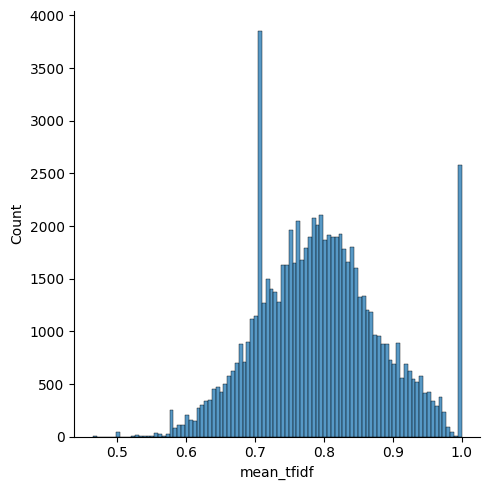

In [35]:
# penguins = sns.load_dataset("penguins")
sns.displot(all_features[mean_tfidf_column_name].to_frame(), x=mean_tfidf_column_name)
# penguins.head()

In [36]:
# all_features.head()['speaker_text'].apply(lambda x: text_to_mean_tfidf(x))
all_features[mean_tfidf_column_name]

0        0.940797
1        0.815491
2        0.721205
3        0.705724
4        0.815491
5        0.940797
6        0.721205
7        0.705724
8        0.815491
9        0.940797
10       0.721205
11       0.705724
12       0.733406
13       0.840483
14       0.840483
15       0.733406
16       0.840483
17       0.733406
18       0.789401
19       0.840884
20       0.840884
21       0.789401
22       0.789401
23       0.840884
24       0.700794
25       0.700794
26       0.700794
27       0.896144
28       0.896144
29       0.896144
30       0.852876
31       0.852876
32       0.922824
33       0.922824
34       0.922824
35       0.822609
36       0.822609
37       0.822609
38       0.798605
39       0.798605
40       0.798605
41       0.859264
42       1.000000
43       0.859264
44       1.000000
45       0.859264
46       1.000000
47       0.963667
48       0.908723
49       0.810000
50       0.963667
51       0.908723
52       0.810000
53       0.963667
54       0.810000
55       0

First axis - texts, second - words 

In [37]:
all_features[['duration', mean_tfidf_column_name]].corr()

,duration,mean_tfidf
duration,1.000000,-0.153973
mean_tfidf,-0.153973,1.000000


In [40]:
all_features.head()

,speaker_text,duration,annotator_emo,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,mean_tfidf
0,я слушаю,5.82,neutral,-0.197958,-0.149894,0.032033,-0.102101,-0.219139,-0.263596,-0.225147,0.258930,0.117051,0.100377,-0.324246,0.258904,-0.508715,-0.215503,0.210882,0.025488,-0.147110,-0.190629,0.025276,-0.075997,-0.391164,0.009545,-0.088486,0.355572,-0.191074,-0.106108,0.104446,0.028415,-0.365087,0.143028,-0.131791,-0.338319,0.686531,0.267851,0.270479,0.176184,-0.286627,-0.086951,0.477265,-0.036456,-0.133732,-0.251715,0.198817,-0.067004,-0.009029,-0.238308,-0.243764,0.087319,-0.516076,-0.528881,-0.456636,-0.244746,0.194040,0.261472,-0.256108,-0.010539,-0.027946,0.404871,0.304832,0.414624,0.264751,-0.202202,0.167245,0.127214,-0.081112,0.220268,0.026994,0.396083,0.021690,0.143788,0.101952,-0.157949,0.263012,-0.242352,-0.191445,0.160875,0.288398,-0.402036,0.055962,-0.068451,-0.186108,-0.110412,0.053057,0.005140,0.102799,0.162183,-0.240076,0.059766,-0.043052,0.120524,-0.309532,-0.178579,-0.170254,0.023768,-0.161257,0.363201,-0.340610,0.136231,-0.447222,0.023024,0.229478,0.415711,-0.064104,0.077425,-0.113667,-0.081131,-0.391203,-0.353643,0.074205,-0.199000,-0.510256,-0.212572,-0.138325,-0.082415,-0.152937,-0.026264,-0.188644,-0.084272,0.393173,-0.289402,0.516674,-0.089059,0.256436,-0.018781,-0.309682,0.048777,-0.532662,-0.461011,-0.024619,0.042296,-0.122076,-0.219262,-0.035282,-0.146745,-0.032820,0.148000,-0.118972,0.267165,-0.027189,-0.350919,0.346585,0.326107,-0.318082,0.022262,-0.274162,-0.482909,0.407158,-0.118547,0.007889,0.207699,-0.558207,-0.231710,0.504233,-0.486445,-0.202590,-0.039634,-0.045369,0.173775,0.277273,0.035539,-0.310294,-0.483012,-0.394369,-0.131762,0.086026,0.327311,0.041434,0.416462,-0.009464,0.442029,0.496967,0.219304,0.002189,0.278207,0.152812,-0.068644,-0.004169,0.268570,0.153320,-0.130606,-0.298030,-0.077796,-0.547992,0.115661,-0.481219,-0.642736,-0.022322,-0.046669,0.279620,0.768871,-0.613441,-0.348806,0.165565,-0.230899,-0.139432,0.437646,-0.179876,-0.176478,0.243698,0.124045,-0.078736,0.143348,-0.040742,0.144629,-0.196814,0.062156,0.254762,-0.264581,-0.212014,-0.147732,0.336298,-0.178571,-0.503756,-0.078845,-0.476782,0.195410,0.311677,0.133584,0.006194,0.382287,-0.169778,0.171826,-0.410383,-0.207939,-0.218626,0.156695,0.021147,-0.236488,-0.293818,-0.159312,0.084891,-0.240532,-0.053193,-0.137024,-0.067664,0.613337,-0.328087,-0.065717,0.249836,-0.026047,-0.429643,-0.080578,0.137631,0.243502,0.386829,-0.018077,-0.074276,0.109758,0.212163,0.030925,-0.166351,0.174804,0.260389,0.113725,0.410525,0.176767,-0.202720,-0.122002,-0.087963,-0.091891,0.137666,-0.254869,-0.422897,0.412493,-0.300738,0.070962,0.371799,-0.192057,-0.241452,0.645597,-0.081838,0.174949,0.122461,0.173219,-0.291513,-0.018067,-0.170438,0.379336,0.465803,0.414921,-0.021657,0.019548,-0.177907,0.418716,-0.037526,0.137094,0.079786,0.309050,-0.074114,0.350627,-0.068739,0.077948,-0.084094,0.113900,-0.028043,-0.415415,0.147565,-0.

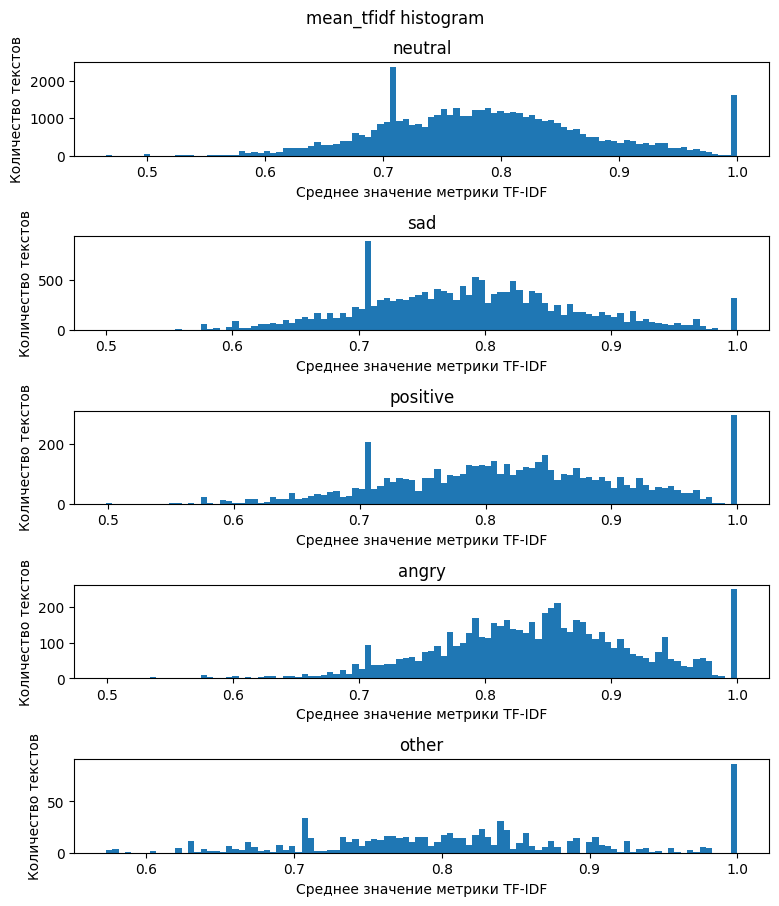

In [43]:
emotions = all_features[EMOTION_COLUMN_NAME].unique()
bins_number = 100
# plt.hist()
fig, axs = plt.subplots(len(emotions), figsize=(8,9))
fig.suptitle(f'{mean_tfidf_column_name} histogram')
fig.tight_layout()
for i in range(len(emotions)):
    fig.tight_layout()
    axs[i].hist(all_features[all_features[EMOTION_COLUMN_NAME] == emotions[i]][mean_tfidf_column_name], bins=bins_number)
    axs[i].set_title(emotions[i])
    axs[i].set_ylabel("Количество текстов")  # Add y-axis label
    axs[i].set_xlabel("Среднее значение метрики TF-IDF")  # Add x-axis label
    # axs[i].plot(x, -y)
# plt.hist(all_features[all_features['annotator_emo'] == emotions[1]]['duration'], bins=bins_number)
None

In [ ]:
# describe_emotion_by_tfidf = pd.DataFrame()
describe_emotion_by_tfidf= None
for i in range(len(emotions)):
    emotion = emotions[i]
    describe_series = all_features[all_features[EMOTION_COLUMN_NAME] == emotions[i]][mean_tfidf_column_name].describe()
    if describe_emotion_by_tfidf is None:
        describe_emotion_by_tfidf = describe_series.to_frame()
        # describe_emotion_by_tfidf = describe_emotion_by_tfidf.rename({describe_series.name: emotion})
        describe_emotion_by_tfidf = describe_emotion_by_tfidf.drop(columns=[describe_series.name])
    describe_emotion_by_tfidf[emotion] = describe_series
    
    
describe_emotion_by_tfidf

,neutral,sad,positive,angry,other
count,48578.000000,16690.000000,5775.000000,5987.000000,803.000000
mean,0.787087,0.787701,0.818064,0.840895,0.817951
std,0.089057,0.084357,0.093656,0.079275,0.101059
min,0.464837,0.499990,0.498693,0.498911,0.572848
25%,0.720509,0.726119,0.753776,0.790302,0.750168
50%,0.782334,0.786439,0.817869,0.843588,0.814536
75%,0.840812,0.839698,0.881562,0.891613,0.886127
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
describe_emotion_by_tfidf = all_features[all_features[EMOTION_COLUMN_NAME] == emotions[i]][mean_tfidf_column_name].describe()
# describe_emotion_by_tfidf.add()

describe_emotion_by_tfidf.to_frame().rename({describe_emotion_by_tfidf.name: '123'})

,mean_tfidf
count,803.000000
mean,0.817951
std,0.101059
min,0.572848
25%,0.750168
50%,0.814536
75%,0.886127
max,1.000000


##### Average coords value for all emotion types

In [21]:
all_features.head()
# for emotion in emotions:
    # all_features[all_features[EMOTION_COLUMN_NAME] == emotion][[str(i) for i in range(0, 300)]].mean(axis=0)

embedding_feautes = [i for i in range(0, 300)]
embedding_feautes.append(EMOTION_COLUMN_NAME)
embedding_feautes
all_features[embedding_feautes].groupby(EMOTION_COLUMN_NAME).mean()
# all_features.columns

NameError: name 'all_features' is not defined

#### Emotions key words

In [ ]:
text_emo_df = all_features[[TEXT_COLUMN_NAME, EMOTION_COLUMN_NAME]].copy()
text_emo_df.head()

,speaker_text,annotator_emo
0,я слушаю,neutral
1,каким стал сбер,sad
2,где родился шерлок холмс,neutral
3,открой в браузере ennio morricone,neutral
4,каким стал сбер,sad


In [ ]:
sample = text_emo_df[TEXT_COLUMN_NAME].head()
    
# emotion_word_counter
emotion_word_counter_dict = {}
for emotion in emotions:
    current_emotion_subdf = text_emo_df[text_emo_df[EMOTION_COLUMN_NAME] == emotion][TEXT_COLUMN_NAME]
    emotion_word_counter = Counter({})
    
    for text in current_emotion_subdf:
        emotion_word_counter.update(text_to_normalized_tokens(text))
    emotion_word_counter_dict[emotion] = emotion_word_counter
    

In [ ]:
text_emo_df.shape

(77833, 2)

In [ ]:
for emotion, word_counter in emotion_word_counter_dict.items():
    print(emotion, ':', list(word_counter.most_common(10)))

neutral : [('я', 3555), ('ты', 3371), ('в', 2771), ('включить', 2760), ('на', 2746), ('фильм', 2401), ('песня', 2027), ('что', 2021), ('как', 1740), ('не', 1730)]
sad : [('я', 1607), ('включить', 1167), ('на', 982), ('ты', 947), ('не', 883), ('в', 815), ('фильм', 755), ('песня', 670), ('как', 646), ('серия', 615)]
positive : [('я', 1242), ('ты', 1174), ('а', 394), ('у', 313), ('салют', 300), ('с', 292), ('в', 292), ('как', 280), ('на', 277), ('что', 263)]
angry : [('ты', 2448), ('я', 1431), ('не', 1060), ('что', 741), ('а', 354), ('в', 320), ('блядь', 311), ('на', 281), ('это', 273), ('как', 257)]
other : [('ты', 150), ('я', 91), ('что', 68), ('не', 59), ('а', 41), ('в', 37), ('на', 34), ('как', 29), ('песня', 29), ('хотеть', 28)]


Most significant words in each emotion

In [ ]:
word_occurancy_in_specific_emotion_ratio = 0.02
most_common_words_number = 10

emotion_most_common_words = {}

for emotion, word_counter in emotion_word_counter_dict.items():
    word_tfidf = []
    for word, occurances_number in emotion_word_counter_dict[emotion].items():
        # count occurances number of this word in all corpus of texts
        if occurances_number/len(emotion_word_counter_dict[emotion]) > word_occurancy_in_specific_emotion_ratio:
            total_occurances_number = 0
            for word_counter in emotion_word_counter_dict.values():
                total_occurances_number += word_counter[word]
            
            word_tfidf.append((word, occurances_number/total_occurances_number))
    
    word_tfidf.sort(key=lambda x: -x[1])
    emotion_most_common_words[emotion] = word_tfidf[:most_common_words_number]

for emotion, words in emotion_most_common_words.items():
    print(emotion, ':', words)


neutral : [('окко', 0.8310344827586207), ('запустить', 0.8305084745762712), ('третий', 0.799410029498525), ('пятый', 0.7837837837837838), ('майнкрафт', 0.7649253731343284), ('тв', 0.7574468085106383), ('клип', 0.7365010799136069), ('супер', 0.735191637630662), ('влад', 0.734982332155477), ('фильм', 0.7342507645259939)]
sad : [('тогда', 0.41832669322709165), ('новость', 0.4162303664921466), ('пять', 0.36192109777015435), ('делать', 0.34063745019920316), ('кино', 0.3377926421404682), ('мультик', 0.32554744525547447), ('мультфильм', 0.3216374269005848), ('машина', 0.31754874651810583), ('второй', 0.30781758957654726), ('большой', 0.2995169082125604)]
positive : [('купаться', 0.7653061224489796), ('молодец', 0.5763888888888888), ('ха', 0.5620915032679739), ('салют', 0.4754358161648177), ('привет', 0.4660633484162896), ('красивый', 0.4553191489361702), ('приятно', 0.45454545454545453), ('спасибо', 0.45318352059925093), ('лайк', 0.4175257731958763), ('тоже', 0.37850467289719625)]
angry : [('

In [ ]:
top_words_quantity = 3
dirty_words = set(['нахуй', 'блядь', 'сука', 'хуй'])
def average_cosine_distance_with_word_emb(df: pd.DataFrame, word_emb: torch.Tensor):
    emodtion_embeddings_cols = list(range(300))
    df_tensor = torch.Tensor(df[emodtion_embeddings_cols].values)
    
    
    word_normalized_emb = F.normalize(word_emb, p=2, dim=0)
    df_normalized_tensor = F.normalize(df_tensor, p=2, dim=1)
    
    
    dot_products = torch.matmul(df_normalized_tensor, word_normalized_emb)
    cosine_distance = 1 - dot_products

    return cosine_distance.mean()

key_word_emotion_df = pd.DataFrame()
for _, words in emotion_most_common_words.items():
    word_i = 0
    words_counter = 0
    while words_counter < top_words_quantity:
    # for word, _ in words[:top_words_quantity]:
        # get word embedding
        word, _ = words[word_i]
        if word in dirty_words:
            symbols_list = list(word)
            symbols_list[0] = '*'
            word = ''.join(symbols_list)
        word_i += 1
        
        current_word_embedding = None
        
        try:
            current_word_embedding = word_to_emb(emb, vocab, word)
        except KeyError:
            continue
        
        average_cosine_distances = []
        for emotion in emotions:
            
            average_cosine_distance = float(average_cosine_distance_with_word_emb(all_features[all_features[EMOTION_COLUMN_NAME] == emotion], current_word_embedding))
            average_cosine_distances.append(average_cosine_distance)
        
        # print(pd.Series(index=emotions, data=average_cosine_distances))
        key_word_emotion_df[word] = pd.Series(index=emotions, data=average_cosine_distances)
        words_counter += 1
        # count average cosine distance in corpus of text for every emotion
        
key_word_emotion_df

# build plots for every word, group plots by emotion 

,запустить,третий,пятый,тогда,новость,пять,купаться,молодец,ха,тупой,дура,дебил,смешно,крутой,мама
neutral,0.909431,0.783161,0.822833,0.712553,0.857481,0.774207,0.907346,0.820428,0.830249,0.935601,0.836376,0.970031,0.821935,0.898952,0.751516
sad,0.908368,0.779386,0.819216,0.702571,0.852567,0.764612,0.901919,0.815842,0.824474,0.932452,0.829856,0.971758,0.812723,0.899351,0.735599
positive,0.922701,0.756012,0.813952,0.630018,0.799379,0.735959,0.874604,0.711147,0.748354,0.913652,0.759262,0.959449,0.744817,0.866759,0.642523
angry,0.905357,0.744677,0.814870,0.571160,0.806594,0.722065,0.871401,0.697538,0.703461,0.845547,0.635150,0.858263,0.703377,0.867078,0.615922
other,0.925060,0.790630,0.844921,0.675763,0.843223,0.775076,0.895923,0.778215,0.785205,0.917098,0.775290,0.936958,0.783456,0.894292,0.704513


In [ ]:
key_word_emotion_df.shape

(5, 15)

In [ ]:
all_features[all_features[EMOTION_COLUMN_NAME] == 'sad']

,speaker_text,duration,annotator_emo,0,1,2,3,4,5,6,...,291,292,293,294,295,296,297,298,299,mean_tfidf
1,каким стал сбер,3.700000,sad,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,...,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355,0.815491
4,каким стал сбер,3.700000,sad,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,...,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355,0.815491
8,каким стал сбер,3.700000,sad,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,...,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355,0.815491
18,позови мне кого нибудь другого лезть,5.247312,sad,-0.136066,-0.156883,-0.077527,-0.037078,-0.171148,-0.274264,0.136021,...,0.254096,0.028773,-0.019775,0.144353,-0.126587,-0.103447,-0.074806,-0.336040,0.038066,0.789401
36,у меня зуб выпадал,2.577000,sad,-0.196443,-0.196155,-0.055705,-0.202940,-0.122482,-0.106701,0.106749,...,0.072931,-0.189355,-0.131699,0.072780,-0.318196,-0.167991,-0.345626,-0.060804,0.085541,0.822609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77823,включи игру слова наоборот,5.160000,sad,0.198895,-0.278133,0.075254,0.062992,-0.155318,-0.095221,0.015344,...,0.221494,0.120578,-0.061261,0.028258,-0.366848,-0.030970,-0.004477,-0.088137,0.423792,0.883928
77829,львиная семейка,6.220000,sad,-0.084114,0.309478,0.106910,-0.364904,-0.243569,-0.412665,-0.085683,...,0.188963,0.021591,-0.234522,-0.214289,-0.019569,0.245924,0.428772,0.088778,0.031588,0.725484
77830,львиная семейка,6.220000,sad,-0.084114,0.309478,0.106910,-0.364904,-0.243569,-0.412665,-0.085683,...,0.188963,0.021591,-0.234522,-0.214289,-0.019569,0.245924,0.428772,0.088778,0.031588,0.725484
77831,львиная семейка,6.220000,sad,-0.084114,0.309478,0.106910,-0.364904,-0.243569,-0.412665,-0.085683,...,0.188963,0.021591,-0.234522,-0.214289,-0.019569,0.245924,0.428772,0.088778,0.031588,0.725484


<Axes: ylabel='пять'>

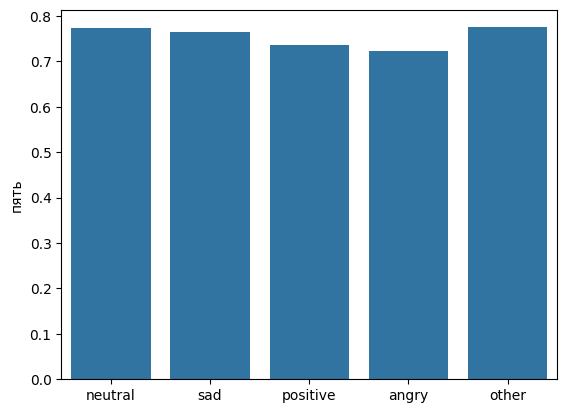

In [ ]:
sns.barplot(data=key_word_emotion_df.iloc[:,5])

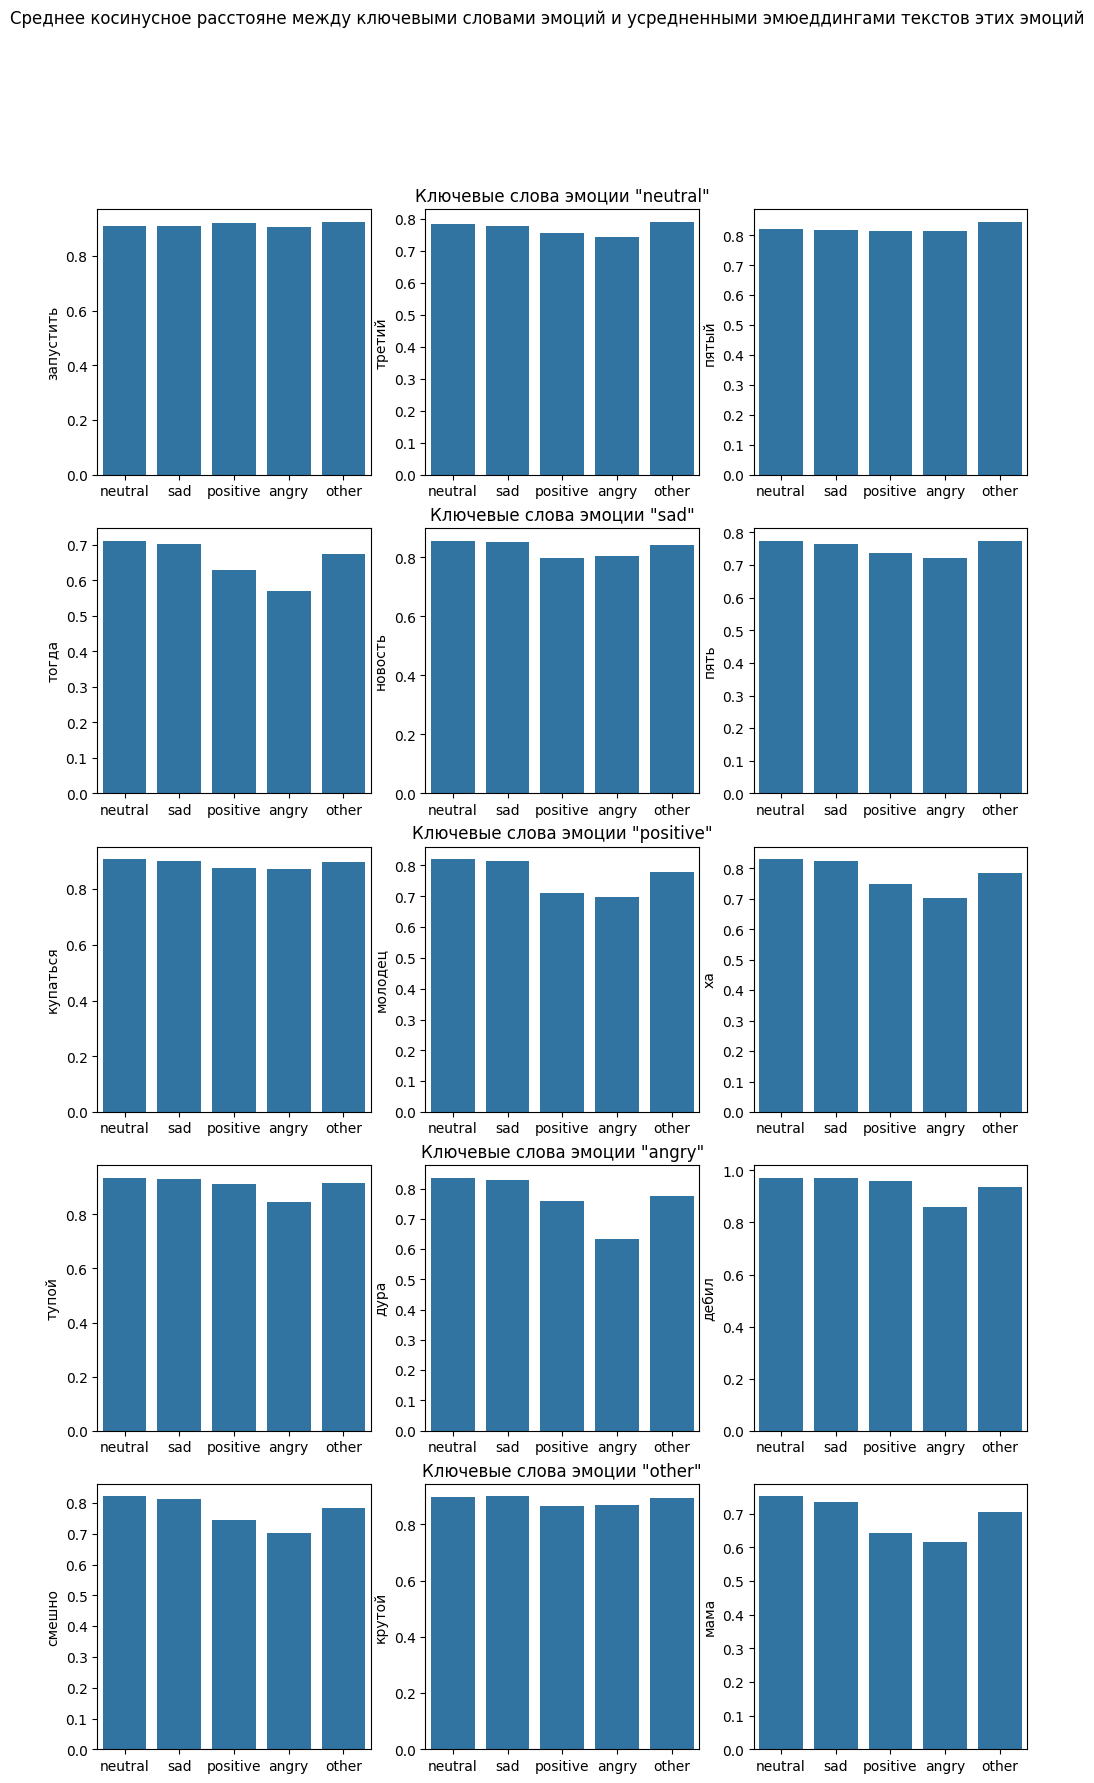

In [ ]:
fig_size_coef = 4
fig, ax = plt.subplots(nrows=len(emotions), ncols=top_words_quantity, figsize=(top_words_quantity * fig_size_coef, len(emotions) * fig_size_coef))
fig.suptitle('Среднее косинусное расстояне между ключевыми словами эмоций и усредненными эмюеддингами текстов этих эмоций')
for i in range(len(emotions)):
    for j in range(top_words_quantity):
        # sns.barplot(key_word_emotion_df.iloc[:, i * top_words_quantity + j])
        column_i = i * top_words_quantity + j
        title = key_word_emotion_df.columns[column_i]
        # sns.barplot(data=key_word_emotion_df.iloc[:, min(13, i * top_words_quantity + j)], ax=ax[i,j])
        sns.barplot(data=key_word_emotion_df.iloc[:, i * top_words_quantity + j], ax=ax[i,j], legend=False)
        if j == (top_words_quantity>>1):
            ax[i,j].title.set_text(f'Ключевые слова эмоции "{emotions[i]}"')

In [ ]:
3 > (5>>1)

True

In [ ]:
key_word_emotion_df.iloc[:,13]

neutral     0.898952
sad         0.899351
positive    0.866759
angry       0.867078
other       0.894292
Name: крутой, dtype: float64

# Train language model

In [32]:
raw_crowd_train.shape, raw_crowd_test.shape

((906953, 9), (79088, 9))

In [33]:
raw_crowd_train.head(2)

,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,475e76f77ac1ed7cabafca740b15b32a,wavs/475e76f77ac1ed7cabafca740b15b32a.wav,2.453,angry,NaN,858305a5450b7bd1288ba0053b1cd1c1,не надо не надо не надо не надо,angry,fa136da095807ea6cd18dd6e2f58d4d0
1,2f9438ef68395c70a8714dc373a49d11,wavs/2f9438ef68395c70a8714dc373a49d11.wav,4.640,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,фозил кори mp три,neutral,3d436884cbbe25373914f8768de494f7


In [34]:
raw_crowd_train[SPEAKER_EMOTION_FIELD_NAME].head()

0      angry
1    neutral
2        NaN
3    neutral
4    neutral
Name: speaker_emo, dtype: object

In [35]:
raw_crowd_train[SPEAKER_TEXT_FIELD_NAME].head()

0            не надо не надо не надо не надо
1                          фозил кори mp три
2                                        NaN
3                  сколько стоит на керамбит
4    афина когда закончится эта телепередача
Name: speaker_text, dtype: object

In [36]:
text_2_emotion_train:pd.DataFrame = raw_crowd_train[[TEXT_2_EMOTION_FEATURE_FIELD_NAME, TEXT_2_EMOTION_TARGET_FIELD_NAME]].dropna().sample(TRAIN_PART_SIZE, random_state=RANDOM_SEED)
text_2_emotion_test:pd.DataFrame = raw_crowd_test[[TEXT_2_EMOTION_FEATURE_FIELD_NAME, TEXT_2_EMOTION_TARGET_FIELD_NAME]].dropna().sample(TEST_PART_SIZE, random_state=RANDOM_SEED)
print(text_2_emotion_train.shape, text_2_emotion_test.shape)
# text_2_emotion_train.head()

(200000, 2) (40000, 2)


In [37]:
X_train_series, y_train_series = text_2_emotion_train[TEXT_2_EMOTION_FEATURE_FIELD_NAME], text_2_emotion_train[TEXT_2_EMOTION_TARGET_FIELD_NAME]
print(X_train_series.shape, y_train_series.shape)
X_test_series, y_test_series = text_2_emotion_test[TEXT_2_EMOTION_FEATURE_FIELD_NAME], text_2_emotion_test[TEXT_2_EMOTION_TARGET_FIELD_NAME]
print(X_test_series.shape, y_test_series.shape)


(200000,) (200000,)
(40000,) (40000,)


In [38]:
TARGET_COL_NAMES:List[str] = sorted(list(y_train_series.unique()))
TARGET_COL_NAMES

['angry', 'neutral', 'positive', 'sad']

In [39]:
TARGET_INDEX_2_NAME=dict(enumerate(TARGET_COL_NAMES))
TARGET_NAME_2_INDEX={v:k for k, v in TARGET_INDEX_2_NAME.items()}
TARGET_INDEX_2_NAME, TARGET_NAME_2_INDEX


({0: 'angry', 1: 'neutral', 2: 'positive', 3: 'sad'},
 {'angry': 0, 'neutral': 1, 'positive': 2, 'sad': 3})

In [40]:
torch.Tensor(pd.get_dummies(y_train_series.head(1000)).astype(int).to_numpy())

tensor([[0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]])

In [41]:
max_words_quantity = text_2_emotion_train[SPEAKER_TEXT_FIELD_NAME].apply(lambda x: len(x.split())).max()
max_words_quantity

np.int64(49)

In [42]:
X_train:torch.Tensor = texts_series_2_tensor(X_train_series, torch_unified_size=max_words_quantity, word_tensor_length=NAVEC_EMBEDDINGS_SIZE)
X_test:torch.Tensor = texts_series_2_tensor(X_test_series, torch_unified_size=max_words_quantity, word_tensor_length=NAVEC_EMBEDDINGS_SIZE)
X_train.shape, X_test.shape

(torch.Size([200000, 49, 300]), torch.Size([40000, 49, 300]))

In [43]:
y_train:torch.Tensor = torch.Tensor(pd.get_dummies(y_train_series, columns=TARGET_COL_NAMES).to_numpy())
y_test:torch.Tensor = torch.Tensor(pd.get_dummies(y_test_series, columns=TARGET_COL_NAMES).to_numpy())

In [28]:
class LSTMModel_many_layers(nn.Module):
    def __init__(self, input_size, hidden_size_1, output_size):
        super(LSTMModel_many_layers, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size_1, batch_first=True, num_layers=30, dropout=0.5)
        self.fc = nn.Linear(hidden_size_1, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) 
        return out

# is_GRU_unit:bool = False
# class GRU(nn.Module):
#     def __init__(self, input_size, output_size=1, hidden_size=10, num_layers=3):
#         super(GRU, self).__init__()
#         self.gru = nn.GRU(
#             input_size=input_size,
#             hidden_size=hidden_size,
#             num_layers=num_layers,
#             batch_first=True,
#             )
#         self.fc = nn.Linear(hidden_size, output_size)

    
#     def forward(self, x):

#         h_0 = torch.zeros(3, batch_size, hidden_size)
#         out, h_n = self.gru(x, h_0)
#         last_hidden_state = out[:, -1, :]
#         output = self.fc(last_hidden_state)
#         return output

# model = LSTMModel_1_layer(input_size, hidden_size_1=5, output_size=output_size)
model = LSTMModel_many_layers(NAVEC_EMBEDDINGS_SIZE, hidden_size_1=10, output_size=len(TARGET_COL_NAMES))

In [29]:
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [30]:
# train_sequences_tensor, train_targets_tensor = torch.tensor(train_sequences, dtype=torch.float32), torch.tensor(train_targets, dtype=torch.float32)
# test_sequences_tensor, test_targets_tensor = torch.tensor(test_sequences, dtype=torch.float32), torch.tensor(test_targets, dtype=torch.float32)


# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

best_model_state = None
min_test_loss:Optional[float] = None

num_epochs = int(10)

loss_values = []
test_loss_values = []
    
for epoch in tqdm(range(num_epochs)):
    model.train()
    

    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_pred = model(X_test)
            test_loss_item = criterion(test_pred.squeeze(), y_test).item()
            train_loss_item = loss.item()
            loss_values.append(train_loss_item)
            test_loss_values.append(test_loss_item)
            print(f'Epoch [{epoch + 1}/{num_epochs}], loss: {train_loss_item:.4f}, test loss: {test_loss_item:.4f}')

            if min_test_loss is None or test_loss_item < min_test_loss:
                min_test_loss = test_loss_item
                best_model_state = deepcopy(model)
            # save best version of model 
            
    # h_0 = torch.zeros(3, batch_size, hidden_size)            

        

  0%|          | 0/100 [00:00<?, ?it/s]

: 

: 

: 

<Axes: >

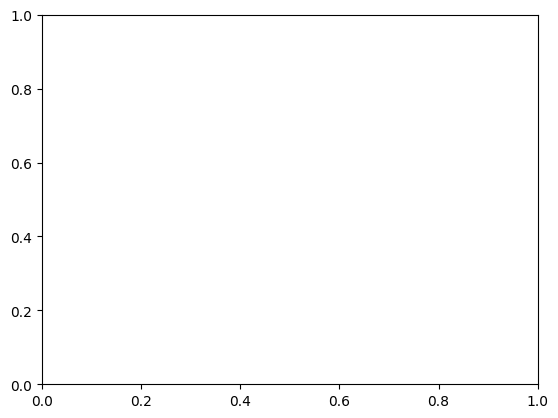

In [ ]:
losses = pd.DataFrame(
    [
        pd.Series(
            loss_values, 
            name ='train'
        ), 
        pd.Series(
            test_loss_values, 
            name ='test'
        )
    ]
).T
sns.lineplot(losses)
# losses

In [ ]:
test_pred = best_model_state(X_test).squeeze()
test_pred.shape, test_pred[:5]

(torch.Size([10000, 4]),
 tensor([[-0.2608,  0.6167, -0.5032,  0.6201],
         [-0.1340,  0.6750, -0.5968,  0.6826],
         [-0.2587,  0.7305, -0.6085,  0.8016],
         [-0.2998,  0.7507, -0.6063,  0.7672],
         [-0.2017,  0.6446, -0.5351,  0.6327]], grad_fn=<SliceBackward0>))

In [ ]:
test_pred_argmax = test_pred.argmax(
    dim=1,
)

In [ ]:
test_pred_argmax[:5]

tensor([3, 3, 3, 3, 1])

In [ ]:
pd.Series(test_pred_argmax).value_counts()

3    6437
1    3563
Name: count, dtype: int64

In [ ]:
# test_pred
y_test_argmax = y_test.argmax(
    dim=1,
)

In [ ]:
pd.Series(y_test_argmax).value_counts()

1    4500
3    3556
0    1076
2     868
Name: count, dtype: int64

In [ ]:
y_test_argmax[:5]

tensor([3, 1, 2, 1, 1])

In [ ]:
# test_targets
ys = pd.concat(
    [
        pd.Series(test_pred_argmax.detach().numpy(), name=PREDICTIONS_COL_NAME), 
        pd.Series(y_test_argmax.detach().numpy(), name=TRUE_COL_NAME),
    ],
    axis=1
)

metrics_report = classification_report(ys[TRUE_COL_NAME], y_pred = ys[PREDICTIONS_COL_NAME], target_names=list(TARGET_NAME_2_INDEX.keys()))
# ys
# pd.Series(test_pred.detach().numpy()).head(), pd.Series(test_targets).head()

/data/vkiselev/projects/univer/deploma/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/vkiselev/projects/univer/deploma/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/vkiselev/projects/univer/deploma/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
print(metrics_report)

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      1076
     neutral       0.46      0.36      0.40      4500
    positive       0.00      0.00      0.00       868
         sad       0.35      0.64      0.45      3556

    accuracy                           0.39     10000
   macro avg       0.20      0.25      0.21     10000
weighted avg       0.33      0.39      0.34     10000



In [ ]:
# pd.Series(y_train.maxa)

AttributeError: 'Tensor' object has no attribute 'maxa'

# Train model only on texts

In [14]:
class DushaEmotion(Enum):
    angry = 0
    neutral = 1
    positive = 2
    sad = 3
dusha_class_names = [emotion.name for emotion in DushaEmotion]

In [15]:
# DushaEmotion['angry']
type(getattr(DushaEmotion,'angry').value)

int

In [16]:
class RuBERTTine2Emotion(Enum):
    admiration = DushaEmotion.positive
    amusement = DushaEmotion.positive
    anger = DushaEmotion.angry
    annoyance = DushaEmotion.angry
    approval = DushaEmotion.neutral # positive
    caring = DushaEmotion.positive
    confusion = DushaEmotion.angry # neutral, sad
    curiosity = DushaEmotion.positive
    desire = DushaEmotion.neutral
    disappointment = DushaEmotion.sad
    disapproval = DushaEmotion.sad
    disgust = DushaEmotion.sad
    embarrassment = DushaEmotion.neutral
    excitement = DushaEmotion.positive
    fear = DushaEmotion.sad
    gratitude = DushaEmotion.neutral
    grief = DushaEmotion.sad
    joy = DushaEmotion.positive
    love = DushaEmotion.positive
    nervousness = DushaEmotion.sad
    optimism = DushaEmotion.positive
    pride = DushaEmotion.positive
    realization = DushaEmotion.neutral
    relief = DushaEmotion.positive
    remorse = DushaEmotion.neutral
    sadness = DushaEmotion.sad
    surprise = DushaEmotion.positive
    neutral = DushaEmotion.neutral


In [103]:
# RuBERTTine2Emotion.admiration
def RuBERTTine2Emotion_name_2_Dusha_emotion(emotion_name:str):
    return getattr(RuBERTTine2Emotion, emotion_name).value.value

RuBERTTine2Emotion_name_2_Dusha_emotion('nervousness')

3

In [18]:
def raw_crowd_ds_2_text_emotion_df(
    raw_crowd:pd.DataFrame,
    text_field_name:str = SPEAKER_TEXT_FIELD_NAME,
    speaker_emotion_field_name:str = SPEAKER_EMOTION_FIELD_NAME
    ):
    # TODO: check is it a right move? (we need claim only markup from authors aggregation) 
    df = raw_crowd[[text_field_name, speaker_emotion_field_name]].dropna().drop_duplicates()
    # labelencoder = LabelEncoder()
    df[speaker_emotion_field_name] = df[speaker_emotion_field_name].apply(lambda x: DushaEmotion[x].value)
    return df

def raw_crowd_ds_2_text_emotion_file_path_df(
    raw_crowd:pd.DataFrame,
    text_field_name:str = SPEAKER_TEXT_FIELD_NAME,
    speaker_emotion_field_name:str = SPEAKER_EMOTION_FIELD_NAME,
    audio_path_field_name:str = AUDIO_PATH_FIELD_NAME,
    ):
    # TODO: check is it a right move? (we need claim only markup from authors aggregation) 
    df = raw_crowd[[text_field_name, speaker_emotion_field_name, audio_path_field_name]].dropna().drop_duplicates()
    df[speaker_emotion_field_name] = df[speaker_emotion_field_name].apply(lambda x: DushaEmotion[x].value)
    return df

In [19]:
raw_crowd_train.head()

,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,475e76f77ac1ed7cabafca740b15b32a,wavs/475e76f77ac1ed7cabafca740b15b32a.wav,2.453000,angry,NaN,858305a5450b7bd1288ba0053b1cd1c1,не надо не надо не надо не надо,angry,fa136da095807ea6cd18dd6e2f58d4d0
1,2f9438ef68395c70a8714dc373a49d11,wavs/2f9438ef68395c70a8714dc373a49d11.wav,4.640000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,фозил кори mp три,neutral,3d436884cbbe25373914f8768de494f7
2,9937036a9c0dba20eecbffddd00f2be2,wavs/9937036a9c0dba20eecbffddd00f2be2.wav,4.341750,neutral,2.0,858305a5450b7bd1288ba0053b1cd1c1,NaN,NaN,NaN
3,fb0ae78586a235018103acec22a80a8f,wavs/fb0ae78586a235018103acec22a80a8f.wav,3.900562,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,сколько стоит на керамбит,neutral,80bc833cf6b3f106d2e8991783a31e2b
4,196dcf9e1aaac46c2aee45e7f6adfb92,wavs/196dcf9e1aaac46c2aee45e7f6adfb92.wav,4.780000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,афина когда закончится эта телепередача,neutral,bd78f079676fa5f1ed17253c9a440cc6


In [20]:
raw_crowd_train.shape

(906953, 9)

In [21]:
raw_crowd_test.head()

,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,9e9961c53ca6eeb440b217e539fbf46c,wavs/9e9961c53ca6eeb440b217e539fbf46c.wav,5.82,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,я слушаю,neutral,4282ddc30d71ef420e202e0c60391e9f
1,0166f65a30354db8282682b1a280e64c,wavs/0166f65a30354db8282682b1a280e64c.wav,3.70,sad,NaN,858305a5450b7bd1288ba0053b1cd1c1,каким стал сбер,neutral,d70dc98ed56e9362eaefefb7b2827c8f
2,d49a6b560155831725a7bdc7d0a96099,wavs/d49a6b560155831725a7bdc7d0a96099.wav,4.38,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,где родился шерлок холмс,neutral,0ee35d2abecf4272ecc8e1539b0839d8
3,c6852b0925797612d7b6724da8cbe7b4,wavs/c6852b0925797612d7b6724da8cbe7b4.wav,8.58,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,открой в браузере ennio morricone,neutral,0855e363c1787df1592f58f7a27ebe13
4,0166f65a30354db8282682b1a280e64c,wavs/0166f65a30354db8282682b1a280e64c.wav,3.70,sad,NaN,a5562e26cd8f1949488a2d1e1e549d97,каким стал сбер,neutral,d70dc98ed56e9362eaefefb7b2827c8f


In [64]:
X_TRAIN_SIZE:int = int(5e3)
X_TEST_FRACTION:float = 0.2
X_train = raw_crowd_ds_2_text_emotion_df(raw_crowd_train)[:X_TRAIN_SIZE]
X_train.head()

,speaker_text,speaker_emo
0,не надо не надо не надо не надо,0
1,фозил кори mp три,1
3,сколько стоит на керамбит,1
4,афина когда закончится эта телепередача,1
5,где проживают дети путина тихонова и воронцова,1


In [23]:
X_train.shape

(10000, 2)

In [24]:
X_train_path:Path = Path('/home/vkiselev/data/other/univer/deploma/dusha/my/text_model/X_train.csv')
X_train.to_csv(X_train_path, index=False)

In [25]:
X_test = raw_crowd_ds_2_text_emotion_df(raw_crowd_test)[:int(X_TRAIN_SIZE*X_TEST_FRACTION)]
print(X_test.shape)
X_test.head()

(2000, 2)


,speaker_text,speaker_emo
0,я слушаю,1
1,каким стал сбер,1
2,где родился шерлок холмс,1
3,открой в браузере ennio morricone,1
12,а там и ева проснулись с утра,2


In [26]:
X_test[SPEAKER_EMOTION_FIELD_NAME].unique()

array([1, 2, 0, 3])

In [27]:
X_test_path:Path = Path('/home/vkiselev/data/other/univer/deploma/dusha/my/text_model/X_test.csv')
X_test.to_csv(X_test_path, index=False)

In [28]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, accuracy_score
# from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
# import torch

# # Load your dataframes
# # X_train and X_test should already be defined with 'speaker_text' and 'speaker_emo'

# # Encode the labels
# label_map = {label: idx for idx, label in enumerate(X_train['speaker_emo'].unique())}
# X_train['label'] = X_train['speaker_emo'].map(label_map)
# X_test['label'] = X_test['speaker_emo'].map(label_map)

# # Load BERT tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# # Tokenize the input texts
# train_encodings = tokenizer(list(X_train['speaker_text']), truncation=True, padding=True)
# test_encodings = tokenizer(list(X_test['speaker_text']), truncation=True, padding=True)

# # Create a dataset class
# class EmotionDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels

#     def __getitem__(self, idx):
#         item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#         item['labels'] = torch.tensor(self.labels[idx])
#         return item

#     def __len__(self):
#         return len(self.labels)

# # Prepare datasets
# train_dataset = EmotionDataset(train_encodings, list(X_train['label']))
# test_dataset = EmotionDataset(test_encodings, list(X_test['label']))

# # Load BERT model for sequence classification
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_map))

# # Define training arguments
# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=1,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     warmup_steps=500,
#     weight_decay=0.01,
#     logging_dir='./logs',
#     logging_steps=10,
#     evaluation_strategy="epoch",
# )

# # Create Trainer instance
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
# )



In [63]:
# Train the model
trainer.train()

NameError: name 'trainer' is not defined

In [121]:
# Evaluate the model
predictions, labels, _ = trainer.predict(test_dataset)
predicted_labels = predictions.argmax(axis=1)

# Print evaluation metrics
print("Accuracy:", accuracy_score(labels, predicted_labels))
print(classification_report(labels, predicted_labels, target_names=list(label_map.keys())))

Accuracy: 0.35


/data/vkiselev/projects/univer/deploma/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TypeError: object of type 'numpy.int64' has no len()

# Load models

## Text

In [29]:
# Load the pretrained emotion classification model for Russian
rubert_tiny2 = pipeline("text-classification", model="seara/rubert-tiny2-russian-emotion-detection-ru-go-emotions")

# Define your texts for classification
texts = [
    "Я очень зол на тебя!",  # Angry
    "Сегодня обычный день.",  # Neutral
    "Мне очень нравится эта идея!",  # Positive
    "Мне грустно и одиноко."  # Sad
]

# Perform inference on the texts
results = rubert_tiny2(texts)

# Print the results
for text, result in zip(texts, results):
    print(f"Text: {text}\nEmotion: {result['label']}, Score: {result['score']:.2f}\n")


Device set to use cpu


Text: Я очень зол на тебя!
Emotion: neutral, Score: 0.21

Text: Сегодня обычный день.
Emotion: neutral, Score: 0.89

Text: Мне очень нравится эта идея!
Emotion: love, Score: 0.32

Text: Мне грустно и одиноко.
Emotion: sadness, Score: 0.72



In [94]:
rubert_tiny2('Мне очень нравится эта идея!')

[{'label': 'love', 'score': 0.32189884781837463}]

In [108]:
def rubert_tiny2_to_dusha_emotion_code(
    text:str,
    label_field_name:str = LABEL_FILED_NAME,  
    model_pipe: transformers.pipelines.text_classification.TextClassificationPipeline = rubert_tiny2,
    )->int:
    return RuBERTTine2Emotion_name_2_Dusha_emotion(model_pipe(text)[0][label_field_name])

rubert_tiny2_to_dusha_emotion_code(text='Мне очень нравится эта идея!')

2

In [30]:
X_test.head()

,speaker_text,speaker_emo
0,я слушаю,1
1,каким стал сбер,1
2,где родился шерлок холмс,1
3,открой в браузере ennio morricone,1
12,а там и ева проснулись с утра,2


In [31]:
y_true = X_test[SPEAKER_EMOTION_FIELD_NAME]

In [32]:
X_test.shape

(2000, 2)

In [33]:
rubert_predictions = pd.DataFrame(rubert_tiny2(X_test[SPEAKER_TEXT_FIELD_NAME].to_list()))

In [83]:
rubert_predictions.tail()

,label,score
1995,neutral,0.263175
1996,admiration,0.866698
1997,approval,0.368896
1998,disapproval,0.533410
1999,neutral,0.722254


In [34]:
y_pred = rubert_predictions['label'].apply(RuBERTTine2Emotion_name_2_Dusha_emotion)
y_pred.head()

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

<RuBERTTine2Emotion.approval: <DushaEmotion.neutral: 1>>

In [35]:
y_true.value_counts()

speaker_emo
1    697
0    600
2    469
3    234
Name: count, dtype: int64

In [36]:
# y_pred = pd.Series(map(lambda x: RuBERTTine2Emotion_name_2_Dusha_emotion(x['label']), rubert_tiny2(X_test[SPEAKER_TEXT_FIELD_NAME].to_list())))
# y_pred.head()

In [37]:
y_true.shape, y_pred.shape

((2000,), (2000,))

In [39]:
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=dusha_class_names))

              precision    recall  f1-score   support

       angry       0.81      0.11      0.19       600
     neutral       0.42      0.92      0.58       697
    positive       0.67      0.36      0.47       469
         sad       0.46      0.25      0.32       234

    accuracy                           0.47      2000
   macro avg       0.59      0.41      0.39      2000
weighted avg       0.60      0.47      0.41      2000



              precision    recall  f1-score   support

       angry       0.81      0.11      0.19       600
     neutral       0.42      0.92      0.58       697
    positive       0.67      0.36      0.47       469
         sad       0.46      0.25      0.32       234

    accuracy                           0.47      2000
   macro avg       0.59      0.41      0.39      2000
weighted avg       0.60      0.47      0.41      2000



# Classification metrics (to script)

              precision    recall  f1-score   support

       angry       0.81      0.11      0.19       600
     neutral       0.42      0.92      0.58       697
    positive       0.67      0.36      0.47       469
         sad       0.46      0.25      0.32       234

    accuracy                           0.47      2000
   macro avg       0.59      0.41      0.39      2000
weighted avg       0.60      0.47      0.41      2000



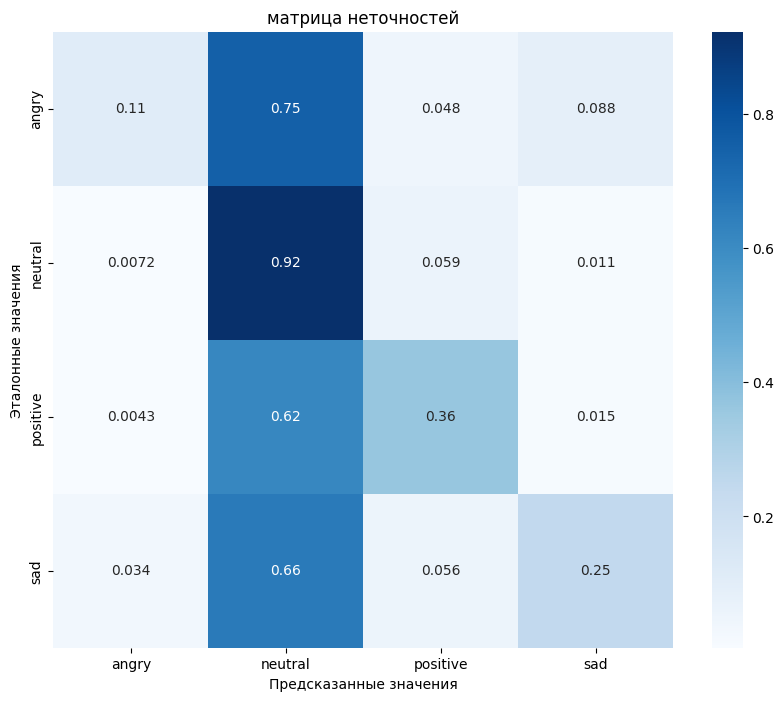

In [121]:
show_all_classification_metrics(
    y_true=y_true,
    y_pred=y_pred,
    class_names=dusha_class_names,
)

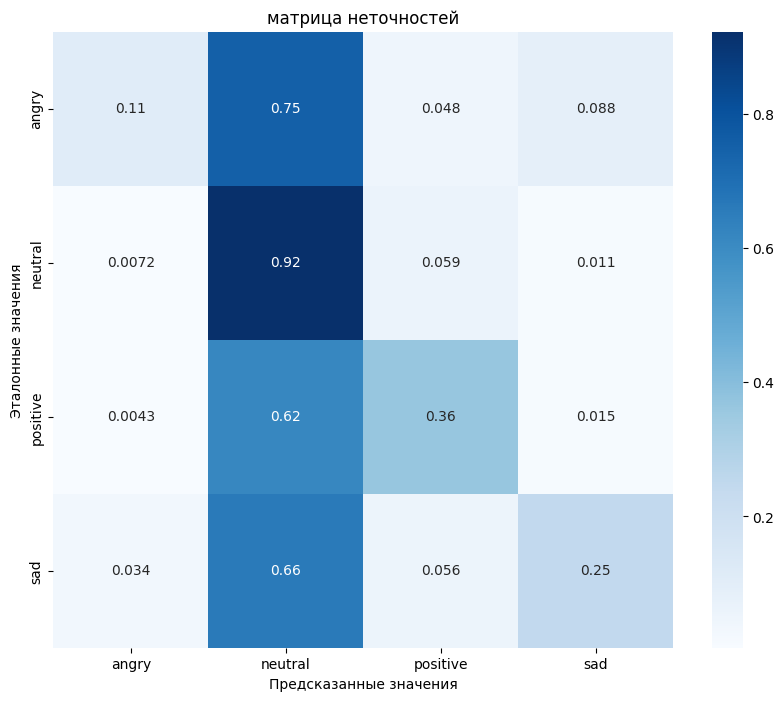

In [40]:
# Now you can call the function with the class names
plot_confusion_matrix(
    y_true=y_true, 
    y_pred=y_pred, 
    class_names=dusha_class_names,
)

## Audio

In [41]:
whisper_audio_file_2_transcription(EXAMPLE_AUDIO_PATH)

Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


[' Юрий Дудь и Константин Хабенский']

In [65]:
X_test = raw_crowd_ds_2_text_emotion_file_path_df(raw_crowd_test)[:int(X_TRAIN_SIZE*X_TEST_FRACTION)]
print(X_test.shape)
X_test.head()

(1000, 3)


,speaker_text,speaker_emo,audio_path
0,я слушаю,1,wavs/9e9961c53ca6eeb440b217e539fbf46c.wav
1,каким стал сбер,1,wavs/0166f65a30354db8282682b1a280e64c.wav
2,где родился шерлок холмс,1,wavs/d49a6b560155831725a7bdc7d0a96099.wav
3,открой в браузере ennio morricone,1,wavs/c6852b0925797612d7b6724da8cbe7b4.wav
12,а там и ева проснулись с утра,2,wavs/64a7aa17132c3e4b7be1aaed5fc88090.wav


In [66]:
# Set the number of threads to use
torch.set_num_threads(20)

# Verify the number of threads being used
print(f"Number of threads used: {torch.get_num_threads()}")

# Your transformer ASR model code here

Number of threads used: 20


In [67]:
X_test[TRANSCRIBED_KEYWORD] = X_test[AUDIO_PATH_FIELD_NAME].progress_apply(lambda x: whisper_audio_file_2_transcription(crowd_test_wav_path_2_abs_path(path=x)))
X_test.head()

  1%|          | 8/1000 [00:25<59:47,  3.62s/it]

In [79]:
X_test[TRANSCRIBED_KEYWORD] = X_test[TRANSCRIBED_KEYWORD].apply(lambda x: EMPTY.join(x))
X_test[TRANSCRIBED_KEYWORD].head()

0                            Я слушаю.
1                     Каким стал сбер?
2            Где родился Шерлок Холмс?
3      Открыв браузере Эннио Моррисон.
12      А там и Ева проснулись с утра.
Name: transcribed, dtype: object

In [114]:
X_test[RUBERT_TINY2_MODEL_NAME] = X_test[TRANSCRIBED_KEYWORD].progress_apply(rubert_tiny2_to_dusha_emotion_code)

100%|██████████| 1000/1000 [00:02<00:00, 440.53it/s]


In [115]:
X_test[RUBERT_TINY2_MODEL_NAME].value_counts()

rubert_tiny2
1    707
2    199
3     53
0     41
Name: count, dtype: int64

In [77]:
(DUSHA_CROWD_TEST_DIR_PATH / 'wavs/9e9961c53ca6eeb440b217e539fbf46c.wav').exists()

True

In [123]:
y_true.head()

0     1
1     1
2     1
3     1
12    2
Name: speaker_emo, dtype: int64

In [124]:
y_pred = X_test[RUBERT_TINY2_MODEL_NAME]

0     1
1     2
2     2
3     1
12    1
Name: rubert_tiny2, dtype: int64

In [126]:
X_test.head()

,speaker_text,speaker_emo,audio_path,transcribed,rubert_tiny2
0,я слушаю,1,wavs/9e9961c53ca6eeb440b217e539fbf46c.wav,Я слушаю.,1
1,каким стал сбер,1,wavs/0166f65a30354db8282682b1a280e64c.wav,Каким стал сбер?,2
2,где родился шерлок холмс,1,wavs/d49a6b560155831725a7bdc7d0a96099.wav,Где родился Шерлок Холмс?,2
3,открой в браузере ennio morricone,1,wavs/c6852b0925797612d7b6724da8cbe7b4.wav,Открыв браузере Эннио Моррисон.,1
12,а там и ева проснулись с утра,2,wavs/64a7aa17132c3e4b7be1aaed5fc88090.wav,А там и Ева проснулись с утра.,1


              precision    recall  f1-score   support

       angry       0.90      0.12      0.22       301
     neutral       0.40      0.81      0.54       351
    positive       0.37      0.32      0.34       232
         sad       0.53      0.24      0.33       116

    accuracy                           0.42      1000
   macro avg       0.55      0.37      0.36      1000
weighted avg       0.56      0.42      0.37      1000



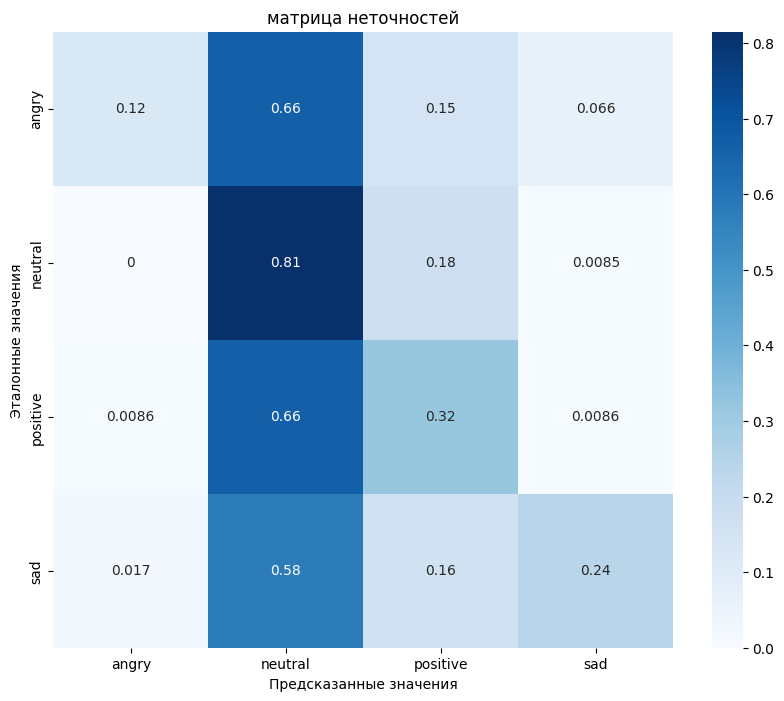

In [127]:
show_all_classification_metrics(
    y_true=X_test[SPEAKER_EMOTION_FIELD_NAME],
    y_pred=X_test[RUBERT_TINY2_MODEL_NAME],
    class_names=dusha_class_names,
)

# Visualizations

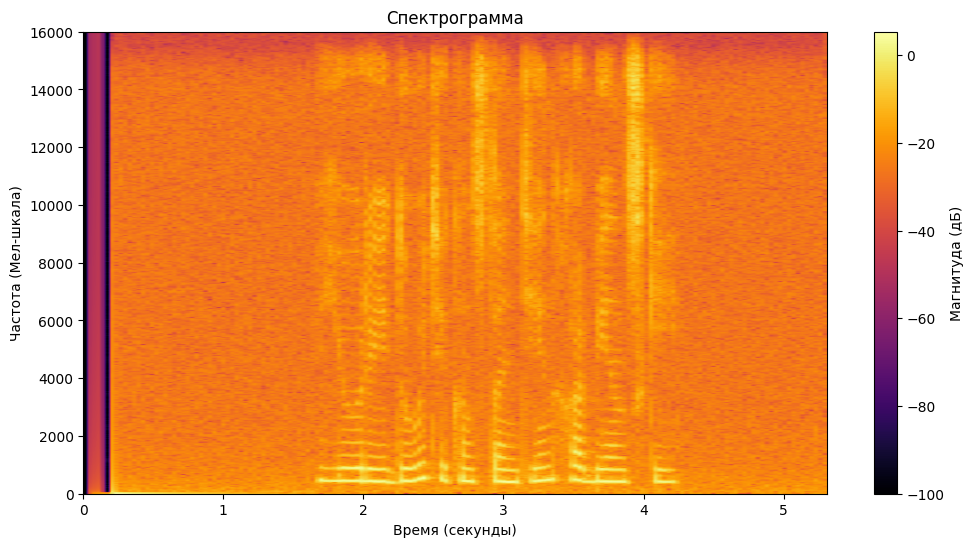

In [85]:
audio_path_2_show_spectrogram(audio_path=EXAMPLE_AUDIO_PATH)

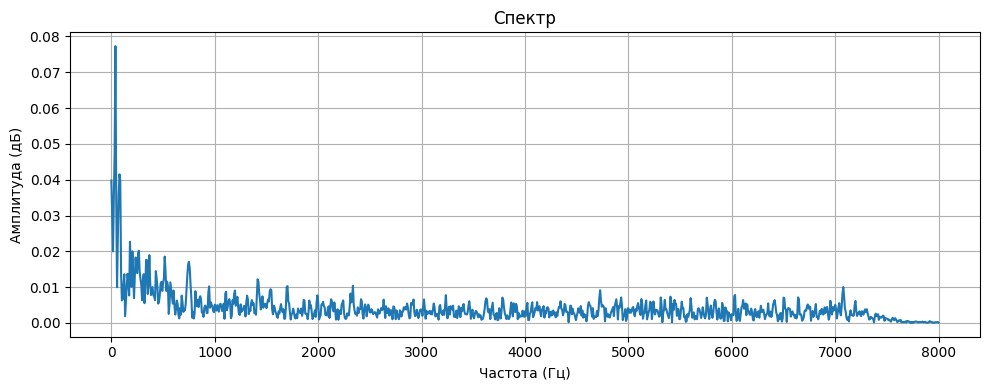

In [6]:
audio_path_2_show_spectrum(EXAMPLE_AUDIO_PATH, frame_index=50)  # Plot the spectrum for frame 50